# Imports

In [1]:
import numpy as np
from Fit import Fit
from funcs import *
from stats import *
import scienceplots
plt.style.use(['grid'])

# Funcs

# RL

In [5]:
if 1:
    path_folder = 'data.new/RLC/'
    V_res, V_l, fase_res, fase_l = [], [], [], []
    freqs = []
    for i in sorted([int(float(i)) for i in os.listdir(path_folder)])[:]:

        path = path_folder+str(i)+'/'

        # V_SGN, V_MTH, dt_CH1, dt_MTH = analize(path, frequency=int(i), force=True, verbose=False)
        
        CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH = analize(path, int(float(i)), force=True, prec=1e-8,verbose=True)
        
        # x=np.linspace(np.min(CH1[0]), np.max(CH1[0])+0.5*np.max(CH1[0]), 100)

        # plt.figure(figsize=(10,4))
        # plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
        # plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
        # plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')
        
        # plt.plot(CH1[0], CH1[1], label='CH1')
        # plt.plot(SGN[0], SGN[1], label='SGN')
        # plt.plot(MTH[0], MTH[1], label='MTH')

        
        # plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
        # plt.scatter(zero_SGN, 0, color='green', label='zero SGN')
        # plt.scatter(zero_MTH, 0, color='blue', label='zero MTH')
        # plt.legend(ncol=3)
        # plt.show()

        V_res.append(V_SGN)
        V_l.append(V_MTH)
        fase_res.append(dt_CH1*float(i))
        fase_l.append(dt_MTH*float(i))
        freqs.append(float(i))

    V_res = np.array(V_res)
    V_l = np.array(V_l)
    fase_res = np.array(fase_res)
    fase_l = np.array(fase_l)
    freqs = np.array(freqs)*2*np.pi

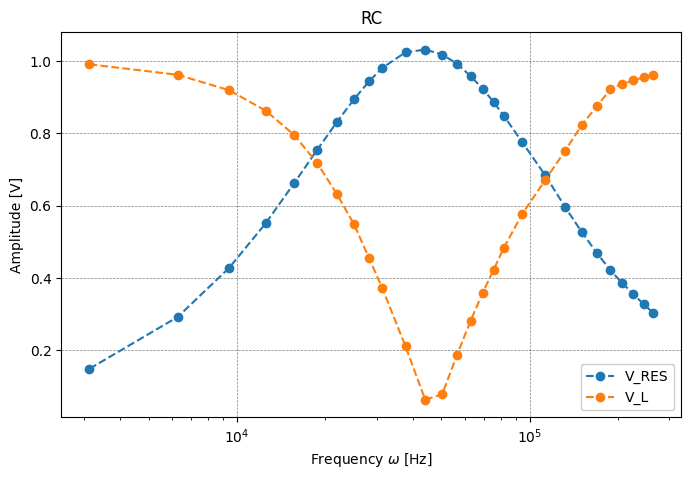

In [6]:
plt.figure(figsize=(8,5))
x = np.linspace(np.min(freqs),np.max(freqs),1000)

# plt.plot(x, H_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
# plt.plot(x, H_C(x*2*np.pi, 1e3*12e-9), label='Teorico')

plt.plot(freqs, V_res, 'o--', label='V_RES')
plt.plot(freqs, V_l, 'o--', label='V_L')
plt.title('RC')
plt.xlabel('Frequency $\omega$ [Hz]')
plt.ylabel('Amplitude [V]')
plt.legend()
plt.xscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


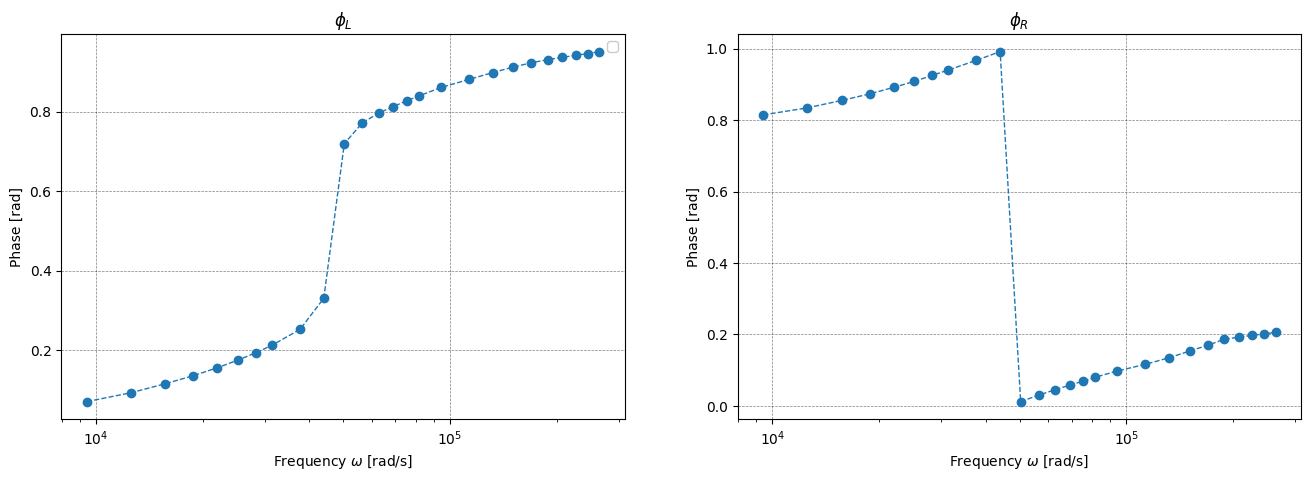

In [7]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)

plt.subplots(1,2,figsize=(16,5))
plt.title('Dati')
plt.subplot(1,2,1)
plt.plot(freqs[2:], fase_l[2:],'o--', lw=1)
plt.title('$\phi_L$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.legend()
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs[2:], fase_res[2:], 'o--', lw=1)
# plt.plot(x, fase_C(x*2*np.pi, 1e3, 12e-9, 0), label='Teorico')
# plt.plot(x, fase_R(x*2*np.pi, 1e3, 12e-9), label='Teorico')
plt.title('$\phi_R$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# plt.savefig('imgs/RC/fasi_no_log.jpeg', bbox_inches='tight', dpi=200)
plt.show()